In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar_resnet import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.utils import *
from lib.lip_model import *
from lib.knn import *
from lib.nin import *
from lib.cifar10_model import *

from lib.cifar10_dcgan import Discriminator, Generator

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


---

Load Models

In [5]:
exp_id = 2

# model_name = 'adv_cifar10_exp%d.h5' % exp_id
# model_name = 'train_cifar10_vae_exp%d.h5' % exp_id
# model_name = 'rot_cifar10_exp%d.h5' % exp_id
# model_name = 'ae_cifar10_exp%d.h5' % exp_id
model_name = 'cifar10_resnet_exp%d.h5' % exp_id

In [6]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=10)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.module
net = net.eval().to('cuda')

In [7]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2]).eval()
config = {'num_steps': 8,
          'step_size': 0.05,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(net, config)

net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.basic_net
net = net.eval().to('cuda')

In [ ]:
net = CIFAR10_VAE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [57]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [44]:
net = CIFAR10_AE((3, 32, 32), latent_dim=128)
net.load_state_dict(torch.load('saved_models/' + model_name))
net = net.eval().to('cuda')

In [112]:
net

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [12]:
ind = np.zeros(x_test.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_test[begin:end].to('cuda'))
        ind[begin:end] = (y_pred.argmax(1).cpu() == y_test[begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))
ind = np.where(ind)[0]

0.9303


In [10]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e-2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[ind].cuda(), y_test[ind].cuda(), 100)

    step: 0; loss: 0.127; l2dist: 0.000
    step: 50; loss: 0.051; l2dist: 0.208
    step: 100; loss: 0.055; l2dist: 0.210
binary step: 0; number of successful adv: 72/100
    step: 0; loss: 0.408; l2dist: 0.000
    step: 50; loss: 0.106; l2dist: 0.273
    step: 100; loss: 0.123; l2dist: 0.285
binary step: 1; number of successful adv: 95/100
    step: 0; loss: 0.852; l2dist: 0.000
    step: 50; loss: 0.113; l2dist: 0.279
    step: 100; loss: 0.110; l2dist: 0.240
    step: 150; loss: 0.145; l2dist: 0.286
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.504; l2dist: 0.000
    step: 50; loss: 0.092; l2dist: 0.255
    step: 100; loss: 0.103; l2dist: 0.247
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.336; l2dist: 0.000
    step: 50; loss: 0.072; l2dist: 0.228
    step: 100; loss: 0.087; l2dist: 0.239
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.123; l2dist: 0.000
    step: 50; loss: 0.054; l2dist: 0.208
    step: 100;

binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.302; l2dist: 0.000
    step: 50; loss: 0.068; l2dist: 0.222
    step: 100; loss: 0.065; l2dist: 0.196
    step: 150; loss: 0.101; l2dist: 0.249
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.126; l2dist: 0.000
    step: 50; loss: 0.057; l2dist: 0.221
    step: 100; loss: 0.061; l2dist: 0.215
binary step: 0; number of successful adv: 65/100
    step: 0; loss: 0.502; l2dist: 0.000
    step: 50; loss: 0.152; l2dist: 0.336
    step: 100; loss: 0.170; l2dist: 0.338
binary step: 1; number of successful adv: 96/100
    step: 0; loss: 0.745; l2dist: 0.000
    step: 50; loss: 0.123; l2dist: 0.297
    step: 100; loss: 0.143; l2dist: 0.293
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.460; l2dist: 0.000
    step: 50; loss: 0.102; l2dist: 0.266
    step: 100; loss: 0.105; l2dist: 0.258
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.311; l2dist: 0.000
    s

    step: 100; loss: 0.108; l2dist: 0.275
    step: 150; loss: 0.102; l2dist: 0.258
    step: 200; loss: 0.206; l2dist: 0.350
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.323; l2dist: 0.000
    step: 50; loss: 0.101; l2dist: 0.266
    step: 100; loss: 0.111; l2dist: 0.267
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.112; l2dist: 0.000
    step: 50; loss: 0.050; l2dist: 0.202
    step: 100; loss: 0.055; l2dist: 0.196
binary step: 0; number of successful adv: 62/100
    step: 0; loss: 0.484; l2dist: 0.000
    step: 50; loss: 0.140; l2dist: 0.320
    step: 100; loss: 0.194; l2dist: 0.358
binary step: 1; number of successful adv: 94/100
    step: 0; loss: 0.920; l2dist: 0.000
    step: 50; loss: 0.131; l2dist: 0.292
    step: 100; loss: 0.154; l2dist: 0.295
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.548; l2dist: 0.000
    step: 50; loss: 0.096; l2dist: 0.254
    step: 100; loss: 0.110; l2dist: 0.251
binary step

    step: 100; loss: 0.196; l2dist: 0.324
    step: 150; loss: 0.342; l2dist: 0.437
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 1.227; l2dist: 0.000
    step: 50; loss: 0.158; l2dist: 0.323
    step: 100; loss: 0.142; l2dist: 0.298
    step: 150; loss: 0.208; l2dist: 0.319
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.806; l2dist: 0.000
    step: 50; loss: 0.163; l2dist: 0.305
    step: 100; loss: 0.204; l2dist: 0.346
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.130; l2dist: 0.000
    step: 50; loss: 0.060; l2dist: 0.225
    step: 100; loss: 0.060; l2dist: 0.224
    step: 150; loss: 0.073; l2dist: 0.246
binary step: 0; number of successful adv: 82/100
    step: 0; loss: 0.297; l2dist: 0.000
    step: 50; loss: 0.085; l2dist: 0.254
    step: 100; loss: 0.084; l2dist: 0.236
    step: 150; loss: 0.129; l2dist: 0.297
binary step: 1; number of successful adv: 96/100
    step: 0; loss: 0.669; l2dist: 0.000
    step: 

    step: 50; loss: 0.130; l2dist: 0.298
    step: 100; loss: 0.172; l2dist: 0.333
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.543; l2dist: 0.000
    step: 50; loss: 0.102; l2dist: 0.276
    step: 100; loss: 0.121; l2dist: 0.282
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.387; l2dist: 0.000
    step: 50; loss: 0.085; l2dist: 0.249
    step: 100; loss: 0.084; l2dist: 0.241
    step: 150; loss: 0.148; l2dist: 0.322
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.128; l2dist: 0.000
    step: 50; loss: 0.062; l2dist: 0.222
    step: 100; loss: 0.066; l2dist: 0.222
binary step: 0; number of successful adv: 64/100
    step: 0; loss: 0.510; l2dist: 0.000
    step: 50; loss: 0.134; l2dist: 0.316
    step: 100; loss: 0.166; l2dist: 0.336
binary step: 1; number of successful adv: 95/100
    step: 0; loss: 0.876; l2dist: 0.000
    step: 50; loss: 0.167; l2dist: 0.334
    step: 100; loss: 0.177; l2dist: 0.323
binary step:

binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.136; l2dist: 0.000
    step: 50; loss: 0.056; l2dist: 0.217
    step: 100; loss: 0.059; l2dist: 0.212
binary step: 0; number of successful adv: 63/100
    step: 0; loss: 0.555; l2dist: 0.000
    step: 50; loss: 0.145; l2dist: 0.312
    step: 100; loss: 0.153; l2dist: 0.332
binary step: 1; number of successful adv: 95/100
    step: 0; loss: 0.981; l2dist: 0.000
    step: 50; loss: 0.118; l2dist: 0.299
    step: 100; loss: 0.144; l2dist: 0.299
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.570; l2dist: 0.000
    step: 50; loss: 0.110; l2dist: 0.280
    step: 100; loss: 0.115; l2dist: 0.286
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.458; l2dist: 0.000
    step: 50; loss: 0.104; l2dist: 0.264
    step: 100; loss: 0.122; l2dist: 0.275
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.131; l2dist: 0.000
    step: 50; loss: 0.059; l2dist: 0.220
    st

    step: 50; loss: 0.089; l2dist: 0.253
    step: 100; loss: 0.091; l2dist: 0.261
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.125; l2dist: 0.000
    step: 50; loss: 0.057; l2dist: 0.225
    step: 100; loss: 0.056; l2dist: 0.210
    step: 150; loss: 0.070; l2dist: 0.224
binary step: 0; number of successful adv: 59/100
    step: 0; loss: 0.564; l2dist: 0.000
    step: 50; loss: 0.148; l2dist: 0.333
    step: 100; loss: 0.147; l2dist: 0.322
    step: 150; loss: 0.217; l2dist: 0.410
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 0.313; l2dist: 0.000
    step: 50; loss: 0.106; l2dist: 0.272
    step: 100; loss: 0.095; l2dist: 0.256
    step: 150; loss: 0.128; l2dist: 0.295
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.273; l2dist: 0.000
    step: 50; loss: 0.081; l2dist: 0.239
    step: 100; loss: 0.123; l2dist: 0.269
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.261; l2dist: 0.000
    step: 

    step: 150; loss: 0.049; l2dist: 0.160
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.191; l2dist: 0.000
    step: 50; loss: 0.042; l2dist: 0.177
    step: 100; loss: 0.040; l2dist: 0.161
    step: 150; loss: 0.046; l2dist: 0.168
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.123; l2dist: 0.000
    step: 50; loss: 0.053; l2dist: 0.211
    step: 100; loss: 0.057; l2dist: 0.197
binary step: 0; number of successful adv: 52/100
    step: 0; loss: 0.623; l2dist: 0.000
    step: 50; loss: 0.151; l2dist: 0.328
    step: 100; loss: 0.203; l2dist: 0.384
binary step: 1; number of successful adv: 90/100
    step: 0; loss: 1.584; l2dist: 0.000
    step: 50; loss: 0.150; l2dist: 0.332
    step: 100; loss: 0.157; l2dist: 0.291
binary step: 2; number of successful adv: 96/100
    step: 0; loss: 5.629; l2dist: 0.000
    step: 50; loss: 0.397; l2dist: 0.450
    step: 100; loss: 0.147; l2dist: 0.248
    step: 150; loss: 0.118; l2dist: 0.242
    step: 20

    step: 100; loss: 0.063; l2dist: 0.231
binary step: 0; number of successful adv: 87/100
    step: 0; loss: 0.227; l2dist: 0.000
    step: 50; loss: 0.051; l2dist: 0.203
    step: 100; loss: 0.057; l2dist: 0.186
binary step: 1; number of successful adv: 99/100
    step: 0; loss: 0.253; l2dist: 0.000
    step: 50; loss: 0.050; l2dist: 0.195
    step: 100; loss: 0.041; l2dist: 0.165
    step: 150; loss: 0.076; l2dist: 0.204
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.174; l2dist: 0.000
    step: 50; loss: 0.042; l2dist: 0.180
    step: 100; loss: 0.036; l2dist: 0.145
    step: 150; loss: 0.039; l2dist: 0.156
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.141; l2dist: 0.000
    step: 50; loss: 0.041; l2dist: 0.178
    step: 100; loss: 0.034; l2dist: 0.145
    step: 150; loss: 0.055; l2dist: 0.176
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.135; l2dist: 0.000
    step: 50; loss: 0.063; l2dist: 0.223
    step: 1

    step: 100; loss: 0.134; l2dist: 0.275
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 0.446; l2dist: 0.000
    step: 50; loss: 0.117; l2dist: 0.274
    step: 100; loss: 0.131; l2dist: 0.265
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.126; l2dist: 0.000
    step: 50; loss: 0.055; l2dist: 0.210
    step: 100; loss: 0.056; l2dist: 0.221
binary step: 0; number of successful adv: 77/100
    step: 0; loss: 0.336; l2dist: 0.000
    step: 50; loss: 0.102; l2dist: 0.275
    step: 100; loss: 0.109; l2dist: 0.272
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 0.202; l2dist: 0.000
    step: 50; loss: 0.075; l2dist: 0.240
    step: 100; loss: 0.070; l2dist: 0.223
    step: 150; loss: 0.083; l2dist: 0.244
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 0.152; l2dist: 0.000
    step: 50; loss: 0.057; l2dist: 0.213
    step: 100; loss: 0.059; l2dist: 0.206
binary step: 3; number of successful adv: 100/100
  

    step: 50; loss: 0.107; l2dist: 0.257
    step: 100; loss: 0.088; l2dist: 0.216
    step: 150; loss: 0.116; l2dist: 0.247
binary step: 2; number of successful adv: 98/100
    step: 0; loss: 2.805; l2dist: 0.000
    step: 50; loss: 0.169; l2dist: 0.308
    step: 100; loss: 0.100; l2dist: 0.211
    step: 150; loss: 0.079; l2dist: 0.201
    step: 200; loss: 0.167; l2dist: 0.249
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 1.642; l2dist: 0.000
    step: 50; loss: 0.106; l2dist: 0.264
    step: 100; loss: 0.068; l2dist: 0.193
    step: 150; loss: 0.099; l2dist: 0.209
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 0.134; l2dist: 0.000
    step: 50; loss: 0.061; l2dist: 0.227
    step: 100; loss: 0.064; l2dist: 0.212
binary step: 0; number of successful adv: 58/100
    step: 0; loss: 0.627; l2dist: 0.000
    step: 50; loss: 0.155; l2dist: 0.337
    step: 100; loss: 0.221; l2dist: 0.424
binary step: 1; number of successful adv: 98/100
    step: 

In [18]:
ind_adv = np.zeros(x_adv.size(0))
with torch.no_grad():
    num = 0
    for i in range(x_adv.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net(x_adv[begin:end].to('cuda'))
        ind_adv[begin:end] = (y_pred.argmax(1).cpu() != y_test[ind][begin:end]).numpy()
        num += (y_pred.argmax(1).cpu() == y_test[ind][begin:end]).sum().numpy()
    print(num / x_adv.size(0))
ind_adv = np.where(ind_adv)[0]

0.0


In [18]:
pert = (x_adv.cpu() - x_test[ind]).view(x_adv.size(0), -1).norm(2, 1)
d1 = (len(ind) - (pert[ind_adv] < 0.5).sum().numpy()) / y_test.size(0)
d2 = (len(ind) - (pert[ind_adv] < 1).sum().numpy()) / y_test.size(0)
d3 = (len(ind) - (pert[ind_adv] < 1.5).sum().numpy()) / y_test.size(0)
print('& %.4f & %.4f & %.4f' % (d1, d2, d3))

& 0.0012 & 0.0001 & 0.0001


In [19]:
pert[ind_adv].mean()

tensor(0.1429)

---

## DkNN

In [8]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['layer4']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [9]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9301


In [10]:
x_adv = pickle.load(open('x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

In [16]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind].numpy()).sum() / y_pred.shape[0])

TypeError: 'int' object is not callable

In [12]:
# attack = DKNNAttack()

from lib.dknn_attack_l2 import DKNNL2Attack
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size, layer):
    x_a = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_a[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layer, m=300, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-2, initial_const=1e-3,
            abort_early=False, random_start=True, guide=2)
    return x_a

num = 1000
ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 1384.783; l2dist: 0.215
    step: 50; loss: 614.108; l2dist: 4.353
    step: 100; loss: 556.940; l2dist: 5.110
    step: 150; loss: 537.592; l2dist: 5.359
    step: 200; loss: 528.239; l2dist: 5.473
    step: 250; loss: 522.978; l2dist: 5.524
    step: 300; loss: 519.639; l2dist: 5.557
    step: 350; loss: 517.231; l2dist: 5.582
    step: 400; loss: 515.285; l2dist: 5.601
    step: 450; loss: 513.837; l2dist: 5.613
tensor(89., device='cuda:0')
binary step: 0; number of successful adv: 89/100
    step: 0; loss: 1637.253; l2dist: 0.215
    step: 50; loss: 823.230; l2dist: 4.173
    step: 100; loss: 760.735; l2dist: 4.711
    step: 150; loss: 738.345; l2dist: 4.882
    step: 200; loss: 727.399; l2dist: 4.978
    step: 250; loss: 721.813; l2dist: 5.030
    step: 300; loss: 718.166; l2dist: 5.065
    step: 350; loss: 715.612; l2dist: 5.089
    step: 400; loss: 713.656; l2dist: 5.112
    step: 450; loss: 712.050; l2dist: 5.130
tensor(89., device='cuda:0')
binary step: 1; n

KeyboardInterrupt: 

In [125]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / len(y_pred)

0.019

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

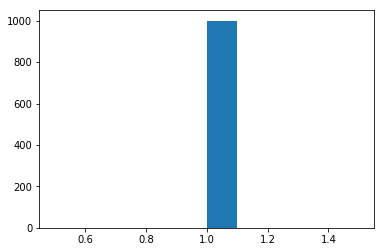

In [126]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [127]:
# y_clean = dknn.classify(x_test[:num])
# ind = (y_clean.argmax(1) == y_test[:num].numpy()) & (y_pred.argmax(1) != y_test[:num].numpy())
dist = np.sqrt(np.sum((x_adv.cpu().detach().numpy() - x_test.numpy()[ind][:num])**2, (1, 2, 3)))
np.mean(dist)

1.0761013

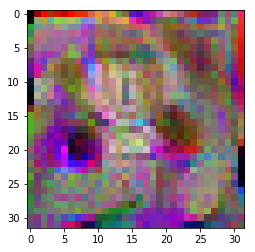

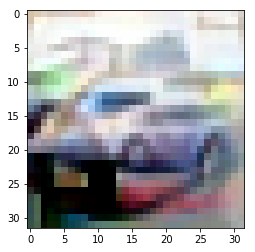

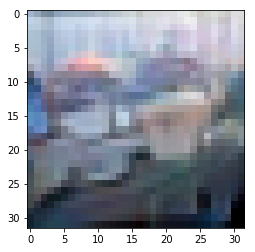

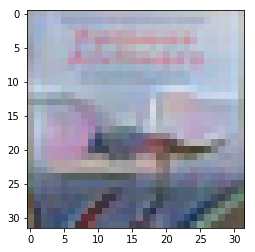

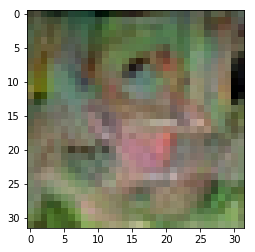

In [23]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().permute(1, 2, 0).numpy())
    plt.show()

---

## RotNet

Train small network on top of pre-trained rotation network

In [27]:
opt = {'num_classes': 4, 'num_stages': 4}
net = NetworkInNetwork(opt)

In [28]:
net.load_state_dict(torch.load('saved_models/model_net_epoch200')['network'])

In [29]:
net = net._feature_blocks

In [30]:
net_wrap = NINWrapper(net, block=2)
net_wrap = net_wrap.cuda().eval()

In [33]:
# net_wrap.fc = nn.Sequential(
#     nn.Linear(12288, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 200),
#     nn.ReLU(inplace=True),
#     nn.Linear(200, 128))
net_wrap.fc = nn.Sequential(
    nn.Linear(12288, 2000),
    nn.ReLU(inplace=True),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 128))
net_wrap = net_wrap.to('cuda')

In [44]:
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp11.h5'))

In [81]:
net = PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=4)
net.load_state_dict(torch.load('saved_models/rot_cifar10_exp0.h5'))
net_wrap = ResNetWrapper(net, block=3, dim=16384)
for param in net_wrap.parameters():
    param.requires_grad = False
# net_wrap.fc = nn.Sequential(
#     nn.Linear(16384, 2000),
#     nn.ReLU(inplace=True),
#     nn.Linear(2000, 400),
#     nn.ReLU(inplace=True),
#     nn.Linear(400, 128),
# )
net_wrap.fc = nn.Sequential(
    nn.BatchNorm1d(16384),
    nn.Linear(16384, 2000),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(2000),
    nn.Linear(2000, 400),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(400),
    nn.Linear(400, 128),
)
net_wrap.load_state_dict(torch.load('saved_models/transfer_cifar10_exp18.h5'))
net_wrap = net_wrap.to('cuda').eval()

In [82]:
layers = ['fc']

dknn = DKNNL2(net_wrap, x_train, y_train, x_valid, y_valid, layers, 
              k=1, num_classes=10)

In [101]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.7015


In [99]:
with torch.no_grad():
    num = 0
    for i in range(x_test.size(0) // 100):
        begin = i * 100
        end = (i + 1) * 100
        y_pred = net_wrap(x_test[begin:end].to('cuda'))
        num += (y_pred.argmax(1).cpu() == y_test[begin:end]).sum().numpy()
    print(num / y_test.size(0))

0.0011
